Для начала считаем данные в массивы `x` и `y` и построим график

In [1]:
with open('report-80.xy', 'r') as f:
    lines = f.readlines()
    x = [float(n.split()[0]) for n in lines]
    y = [float(n.split()[1]) for n in lines]
    
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(x, y, color='r')
plt.show()

<Figure size 1500x500 with 1 Axes>

Если посмотреть на левую часть графика, то видно, что она чуть задрана. Также, пики распространяются не от нуля, а от какого-то базового значения. И это значение не константное, а тоже подвержено какому-то закону. Выводить этот закон аналитически - это отдельная задача. Но можно оценить его численно как локальный минимум в некоторой окрестности. Константу радиуса окрестности выбирал так, чтобы график тренда смотрелся гладким, но при этом не был недооценённым. Именно поэтому левый хвост я сглаживаю с меньшей окрестностью.

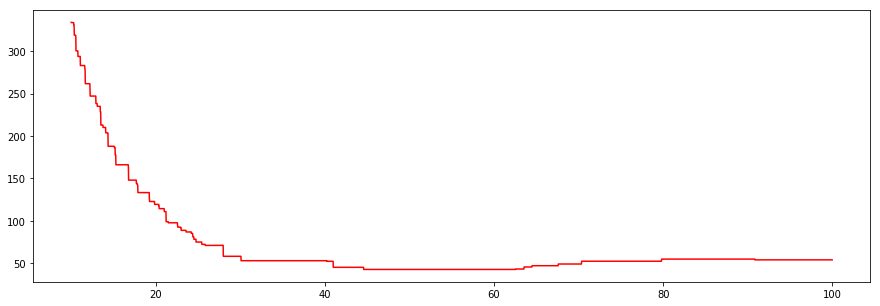

In [2]:
import numpy as np

around1 = len(x) // 100
around2 = len(x) // 10
border = len(x) // 5

def get_slice(y, i, around):
    return y[max(0, i-around):i+around]

trend = np.array(
            [min(get_slice(y, i, around1)) for i in range(border)] +
            [min(get_slice(y, i, around2)) for i in range(border, len(x))]
        )

plt.figure(figsize=(15,5))
plt.plot(x, trend, color='r')
plt.show()

Вычтем тренд из данных.

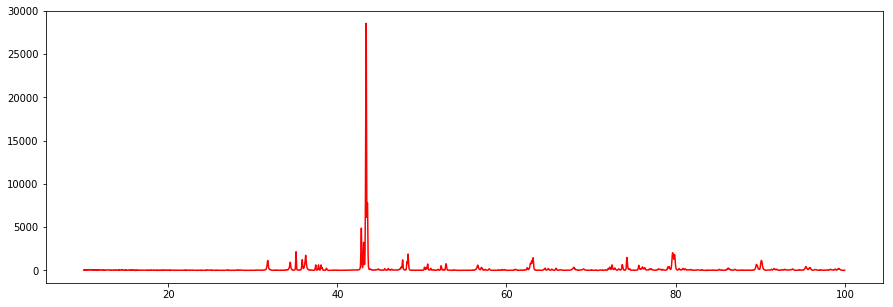

In [3]:
from numpy import histogram
from random import gauss

y_base = np.array(y) - trend

plt.figure(figsize=(15,5))
plt.plot(x, y_base, color='r')
plt.show()

Опишем процедуру оценки расположения и оценки величин пиков.
Пусть есть некоторая функциональная зависимость `y(x)` которая по гипотезе представляет собой сумму Гауссианов.
нужно предложить метод оптимизации, который позволит восстановить число этих Гауссианов и их параметры. Это в общем случае называется **обратной задачей**.

*Предпосылка*. В статистике есть модель случайного процесса, которая называется [Mixture Model](https://en.wikipedia.org/wiki/Mixture_model) - когда есть популяция, составленная из нескольких различных групп. Параметры каждой их которых можно описать в виде нормального распределения (или распределений, если нас интересует несколько параметров). У нас в начале есть не группы, случайная выборка `Y` для популяции в целом. Например, выборка роста людей вне зависимости от пола. Задача - разделить эти группы на уровне модели, т.е. восстановить параметры нормальных распределений. Часто решение такой задачи осуществляется с помощью [EM-алгоритма](https://ru.wikipedia.org/wiki/EM-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC).

*Гипотеза*. Процесс анализа хроматограмм фактически сводится к анализу **гистограммы** (т.е. приближения функции распределения) такого случайного процесса.

*Метод*. 
1. По гистограмме сгеренируем достаточно большую случайную выборку, которая будет обладать свойствами, сходными с неизвестным нам процессом.
2. К этой выборке применим EM-алгоритм для определения параметров смешанных нормальных распределений.
3. Оценим качество модели каким-то подходящим способом. Сейчас я сделал СКО (RMSE), но, кажется, для физхимических процессов лучше применять априорное знание о составе смеси.

In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
from sklearn.mixture import GaussianMixture as gmm
from scipy.stats import norm

def process_data(x, y, N_SAMPLES=200000, N_PEAKS=10, CONV_ERROR=1e-5):
    # нарисуем y
    print("Исходные данные")
    plt.figure(figsize=(15,1))
    plt.plot(x, y, color='r')
    plt.show()

    # почитаем полезные величины
    min_x = min(x)
    width_x = max(x) - min(x)
    weight_y = sum(y)
   
    # отнормируем данные, чтобы интеграл по ним был равен 1.
    probs = np.array(y) / weight_y
      
    # нарисуем распределение
    print("Распределение на основе исходных данных")
    plt.figure(figsize=(15,1))
    plt.plot(x, probs, color='r')
    plt.show()
    
    # сгенерируем достаточно большую выборку и проверим, что её гистограмма похожа на оригинальное распределение
    samples = np.random.choice(len(probs), size=N_SAMPLES, p=probs)
    print("Гистограмма сгенерированной выборки")
    plt.figure(figsize=(15,1))
    plt.hist(samples, bins=len(probs))
    plt.show()
    
    # обучим модель
    model = gmm(
        n_components=N_PEAKS,      # число гауссиан
        covariance_type="diag",    # какие ковариации считать. Тут - только диагональные, которые, по сути, дисперсия.
        init_params="kmeans",      # как будут проинициализированы исходные значения модели.
        tol=CONV_ERROR,            # параметр сходимости метода
        max_iter=200               # максимум итераций
    )
    model.fit(samples.reshape((-1, 1)))
    print("Модель сошлась за {} итераций".format(model.n_iter_))
    
    # соберём все результаты в тройки (μ, σ, w)
    result = list(
            zip(
                model.means_.T[0],                           # μ - матожидание
                [v ** .5 for v in model.covariances_.T[0]],  # σ - корень из дисперсии
                model.weights_,                              # w - коэффициент пропорциональности
            )
        )

    # приведём эти данные к масштабу исходных данных
    result_original = [
        (
            μ * width_x / len(x) + min_x, 
            σ * width_x / len(x), 
            w * width_x / len(x) * weight_y # новый коэффициент пропорциональности фактически равен площади под кривой
        )
        for (μ, σ, w) in result
    ]
    
    # отсортируем по площади
    result_original.sort(reverse=True, key=lambda x: x[2])
    
    # построим график по модели
    y_predicted = [0 for _ in x]
    for μ, σ, w in result_original:
        for i in range(len(y_predicted)):
            y_predicted[i] += norm.pdf(x[i], loc=μ, scale=σ) * w
    
    print("Данные, полученные от модели")
    plt.figure(figsize=(15,2))
    plt.plot(x, y)
    plt.plot(x, y_predicted)
    plt.show()
    
    return result_original

Применим сначала к красивому кусочку.

Ищем 6 компонентов
Исходные данные


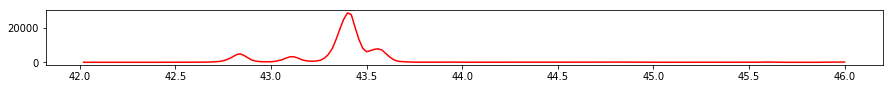

Распределение на основе исходных данных


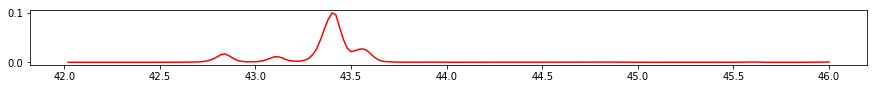

Гистограмма сгенерированной выборки


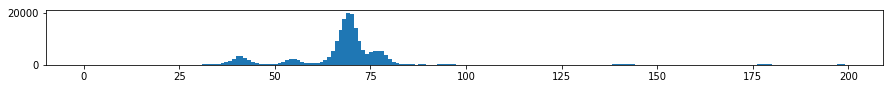

Модель сошлась за 37 итераций
Данные, полученные от модели


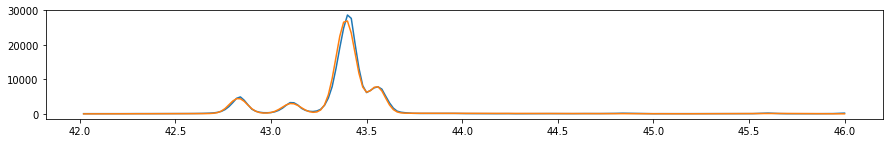

(43.3915544362856, 0.05089330468059562, 3448.2234955514605)
(43.55520949428404, 0.04266846841378224, 812.6037847214013)
(42.82898904408771, 0.046534172824533586, 510.8699510869362)
(43.64544807236264, 0.8857910002978131, 476.6293226640239)
(43.10706101837869, 0.04906673876608332, 353.47994722582297)
(45.647323477770406, 0.22757572223783853, 76.36397874629039)
Ищем 10 компонентов
Исходные данные


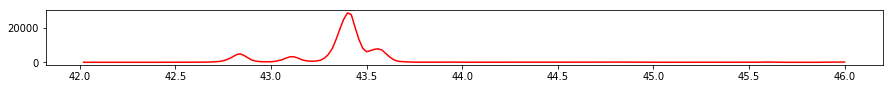

Распределение на основе исходных данных


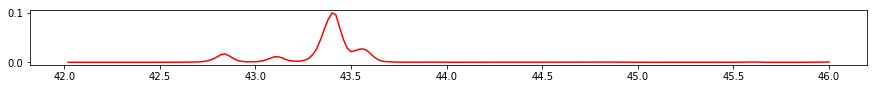

Гистограмма сгенерированной выборки


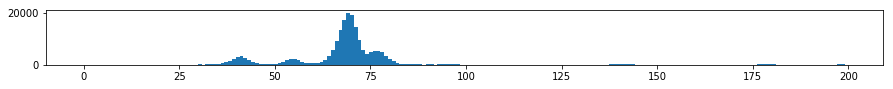

Модель сошлась за 60 итераций
Данные, полученные от модели


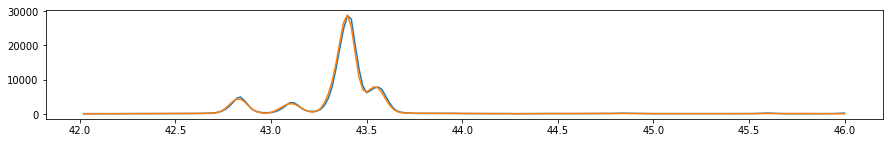

(43.40594516541748, 0.03766162137173356, 1947.1167705372472)
(43.36102004088411, 0.050912620469578763, 1408.5803572725881)
(43.545098320482246, 0.048991057943106424, 950.807517852344)
(42.8297598623491, 0.04685000380599711, 503.49942501966075)
(43.1041082175233, 0.05171747196035608, 383.5238115604638)
(43.740776442592, 0.2944531375755815, 152.73054763722666)
(42.59974983139729, 0.327370856254493, 130.61858930535405)
(44.701446947291956, 0.2928020590250831, 98.77508459319665)
(45.672614120239835, 0.205132966275676, 73.3538275013956)
(45.174000066336106, 0.31507791011681063, 29.16454872132851)


In [35]:
# из-за случайности в инициализации весов в общем случае решение не устойчивое
print("Ищем 6 компонентов")
res = process_data(x[1600:1800], y_base[1600:1800], N_PEAKS=6)
print(*res, sep='\n')
print("Ищем 10 компонентов")
res = process_data(x[1600:1800], y_base[1600:1800], N_PEAKS=10)
print(*res, sep='\n')

Видно, что при увеличении числа гауссианов модель начинает превращать один пик в "стопку" из нескольких очень близких. Поэтому выбор изначального числа пиков должен быть обоснован. Есть два предложения:
1. Делать сразу заведомо большее число пиков, а затем их кластеризовать и склеивать автоматически.
2. Вычислять пачку локальных максимумов, превосходящих какой-то заданный порог (сообразный эксперименту) и применять метод уже исходя из предпосчитанного числа пиков.

Ну а теперь на всех данных.

Ищем 100 компонентов
Исходные данные


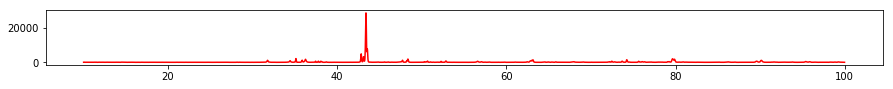

Распределение на основе исходных данных


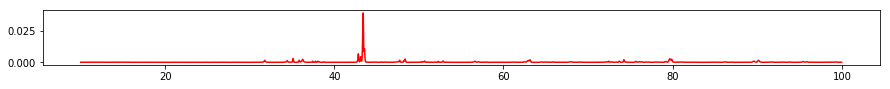

Гистограмма сгенерированной выборки


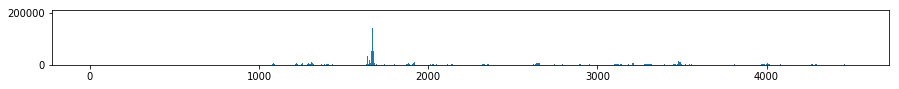

Модель сошлась за 12 итераций
Данные, полученные от модели


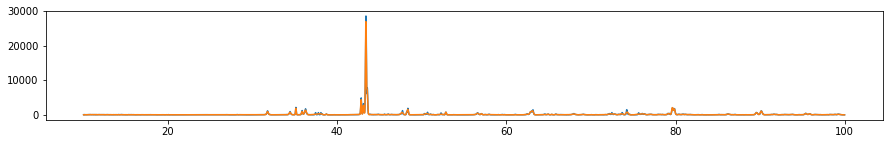

(43.38699538412445, 0.0487288716393932, 3300.498460635456)
(43.539509158236086, 0.05804675256118325, 1032.2018361423727)
(42.82555443320082, 0.04741527398489642, 515.975401764612)
(79.6263817557616, 0.07988620439544417, 412.75705591774033)
(43.107703388331046, 0.057631251545255884, 394.4678487070145)
(36.25046714233618, 0.10932926442742098, 367.5445555327597)
(79.85742481554733, 0.07968783253190112, 333.5430084630095)
(90.13334680652015, 0.11242084036438114, 300.4859754020603)
(63.104980684967, 0.0970031191305584, 276.97767340792603)
(74.27419244507088, 0.12887831738960479, 258.8383096449169)
(47.65994060374045, 0.1294365204991269, 221.56401779723947)
(48.35982012548176, 0.05974389385734986, 212.7690272998354)
(35.113282373799265, 0.04238484447498821, 202.34213204099083)
(62.87188653006325, 0.09802562313222418, 201.4725445486924)
(89.56724183026195, 0.12233284975667355, 192.86933254817046)
(31.764569112632383, 0.0844715696949515, 188.00746405942672)
(50.54957566481957, 0.19305309263385

In [39]:
print("Ищем 100 компонентов")
res = process_data(x, y_base, N_PEAKS=100, N_SAMPLES=5000000, CONV_ERROR=1e-3)
print(*res, sep='\n')